# Project Description

To learn "Time Series", you are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set.
Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

* Robust model? :
    robust estimation. An estimation technique which is insensitive to small departures from the idealized assumptions which have been used to optimize the algorithm.

## File Description

* sales_train.csv : training set. Daily historical data from January 2013 to October 2015
* test.csv : the test set. You need to forecast the sales for these shops and products for November 2015
* sample_submission.csv : sample submission with correct format
* items.csv : supplemental information about the itmes categories
* shops.csv : supplemental information about the shops

## Data fields

* ID : an tuple of (Shop, Item) within the test set
* shop_id : unique identifier of a shop
* item_id : unique identifier of a product
* item_cateogory_id : unique identifier of item category
* item_cnt_day : number of products sold. You are predicting a monthly amount of this measure
* item price : current price of an item
* date : date in format dd/mm/yyyy
* date_block_num : a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name : name of item
* shop_name : name of shop
* item_category_name : name of item category

# Methodology going to be used

### : Time series

### Importing Packages

In [1]:
# Import basic packages
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating data formats

# Import packages for visualization
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# Import packages for time series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# Settings
import warnings
warnings.filterwarnings ("ignore")

In [2]:
# Import datasets
train = pd.read_csv ('./dataset/competitive-data-science-predict-future-sales/sales_train.csv')      #sales data for training
item_cat = pd.read_csv ('./dataset/competitive-data-science-predict-future-sales/item_categories.csv')   #item category id
item = pd.read_csv ('./dataset/competitive-data-science-predict-future-sales/items.csv')    #supplemental information about the itmes categories
sample = pd.read_csv ('./dataset/competitive-data-science-predict-future-sales/sample_submission.csv')   #sample submission with correct format
shops = pd.read_csv ('./dataset/competitive-data-science-predict-future-sales/shops.csv')     #supplemental information about the shops
test = pd.read_csv ('./dataset/competitive-data-science-predict-future-sales/test.csv')    #test set

In [3]:
# Checking the data
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Preprocessing

In [4]:
# Formating the date column correctly
train.date = train.date.apply (lambda x:datetime.datetime.strptime (x, '%d.%m.%Y'))

In [5]:
# checking the data again
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [6]:
# Aggregation: test set에서 monthly basis로 sales prediction 해야하므로 다른 데이터를 monthly level로 aggregation--> Groupby

# Aggregation 방향: row 구분:그룹구분 (date_block_num : 첫번째달로부터 몇번째 달인지 구분, shop_id, item_id), column 구분: 집계(date:min-max, item_price:mean 평균가격, item_cnt_day:sum 총판매갯수)

In [7]:
# group.agg() 함수: groupby with multiple functions 다수의 함수를 적용하기

## groupby만 이용하면 그룹구분을 할 수있는데, 이렇게 Groupby된 여러칼럼을 옆으로 쭉 붙여서 DataFrame으로 만들고 싶을때 group.agg() 함수를 사용한다.
## --> idea generation에서 Aggregation 방향 row구분(그룹구분) 부분은 groupby로 해결하고, column구분(집계) 부분을 agg()함수를 이용한다.

In [8]:
# Aggregation 방법

# 참고: https://rfriend.tistory.com/392

# (1) 함수 리스트(List)를 사용하여 다수의 GroupBy 집계 함수를 동일한 칼럼에 적용하기
# (2) 칼럼과 함수를 매핑한 Dict를 사용하여 칼럼별로 특정 GroupBy 집계 함수를 적용하기
# (3) (이름, 함수)의 튜플 (Tuples of (name, function))을 사용하여 GroupBy 집계 함수에 이름 부여하기

In [9]:
# (2) 칼럼과 함수를 매핑한 Dictionary를 사용하여 칼럼별로 특정 GroupBy 집계 함수를 적용하기 (provide a dictionary which says what aggregation to perform on which column)

monthly_sales = train.groupby (['date_block_num', 'shop_id', 'item_id'])['date','item_price','item_cnt_day'].agg({'date':['min','max'], 'item_price':'mean', 'item_cnt_day':'sum'})


In [10]:
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

### Predict

### - Single Series :

In [11]:
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [12]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


문제를 해결하기 위해서는 store-item combination에서의 다음달의 sales를 예측해야한다.

Time Series의 Prediction 어떻게 진행되는지 알아보기 위해, total sales per month for the entire company를 기준으로 Time Series를 이용해서 Sales를 예측해본다 --> Single

In [13]:
# Entire Company를 기준으로 monthly sales 구하기 위해서 위에서 구해놓은 groupby.agg() 결과를 이용해 
# monthly ('date_block_num'), shop과 item을 망라한 전체 sales ('item_cnt_day'.sum()을 계산한다

monthly_total_sales = train.groupby(['date_block_num'])['item_cnt_day'].sum()

In [14]:
monthly_total_sales.head(8)

date_block_num
0    131479.0
1    128090.0
2    147142.0
3    107190.0
4    106970.0
5    125381.0
6    116966.0
7    125291.0
Name: item_cnt_day, dtype: float64

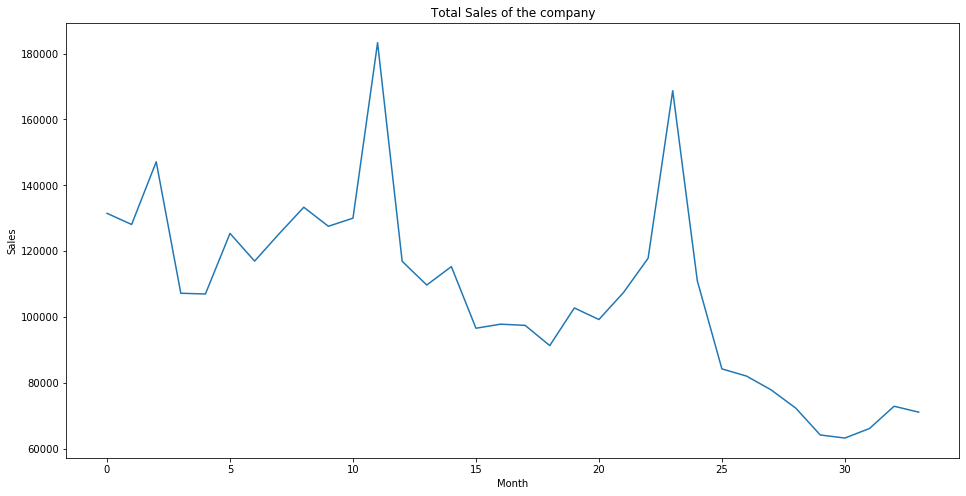

In [15]:
# Visualization
plt.figure (figsize = (16, 8))
plt.title ('Total Sales of the company')
plt.xlabel ('Month')
plt.ylabel ('Sales')
plt.plot(monthly_total_sales);    #info 생략

* Quick Observation from the graph

Sales에 Seasonality가 있다고 보여지기 때문에, 이것을 검증하기위해서 1년(12달)을 기준으로 평균을 내면 이 평균값은 어떻게 변하고 있는지를 봐서 trend를 확인한다
--> Rolling: Groupby와 함께 쓰여지는 Super aggregation함수 이용하면 가능

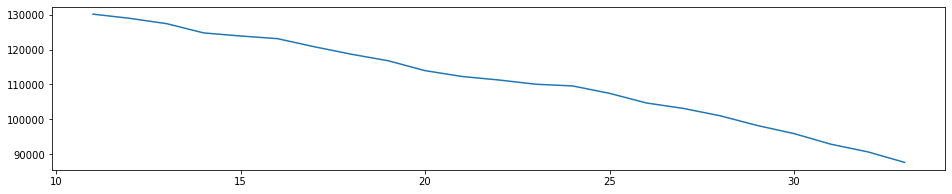

In [16]:
plt.figure (figsize = (16,3))
plt.plot(monthly_total_sales.rolling (window = 12, center = False).mean(), label = "Rolling Mean") ;

seansonality 제외하고 total sales는 계속 떨어지는 추세가 있다.

Time Series, Decomposition을 통해 Trend, Seasonality와 residual을 알아보자.

* Decomposition ? 

--> Time Series를 Systematic(Consistency or recuurency and can be described and modeled)와 Non-systematic(components of the time series that cannnot be directly modeled) component로 나누는게 중요

* Systematic 
1. Level : The average value in the series
2. Trend : The increasing or decreasing value in the series
3. Seasonality : The repeating short-term cycle in the series

* Non-systematic
1. Noise: The random variation in the series

 : A series is thought to be an aggregate or combination of these four components. All series have a level and noise. The trend and seasonality components are optional.
 
 : combining either additively or multiplicatively.

How to decompose ?

* Additive Model (가법모델) : 성분들이 더해져서 구성되어, 구성 성분들의 효과가 만들어내는 변이(변동의 크기)는 '양적으로' 증가

y(t) = Level + Trend + Seasonality + Noise 

* Multiplicative Model (승법모델) : 성분들이 곱해져서 구성되며, 구성 성분들의 효과가 만들어내는 변이(변동의 크기)가 '비례적으로'증가한다

y(t) = Level * Trend * Seansonality * Noise

<Figure size 1152x864 with 0 Axes>

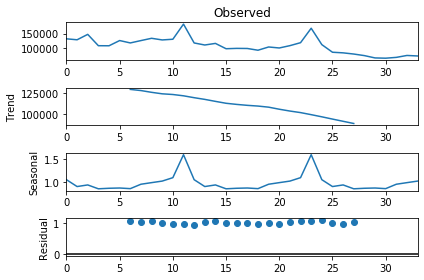

In [17]:
import statsmodels.api as sm

# Decomposition with multiplicative model
res = sm.tsa.seasonal_decompose (monthly_total_sales.values, freq = 12, model = 'multiplicative')

# Visualization
plt.figure (figsize = (16, 12))
fig = res.plot() 
fig.show() 

<Figure size 1152x864 with 0 Axes>

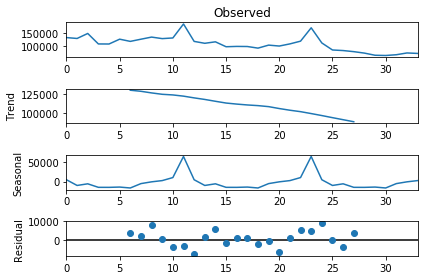

In [18]:
# Decomposition with Additive Model

res = sm.tsa.seasonal_decompose (monthly_total_sales.values, freq = 12, model = 'additive')
plt.figure (figsize = (16, 12))
fig = res.plot()
fig.show()